## EL KETTANEH Joseph - M1 SD

# TP 4 - Support Vector Machine

In [43]:
import numpy as np
import pandas as pd

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#To plot the graph embedded in the notebook
%matplotlib inline
import sklearn.datasets
from IPython.display import Image

from sklearn import datasets
from sklearn.datasets import make_blobs, fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from numpy.linalg import norm


from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import pandas as pd


# Accuracy 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

# 1 Problème jouet

In [214]:
# we create two clusters of random points
n_samples_1 = 300
n_samples_2 = 300
centers = [[1, 1], [-1, -1]]
clusters_std = [0.3, 0.3]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=5,
    shuffle=False,
)


#### Pour pouvoir entrainer un SVM il faut que D = {(xi,yi) ∈ X × {−1,1},i = 1,...,n}

In [215]:
y[y==1] = -1
y[y==0] = 1

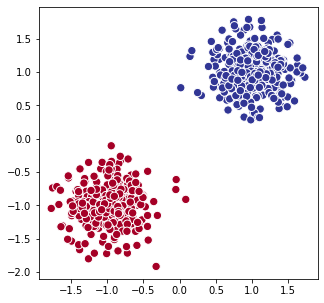

In [216]:
plt.subplots(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y,cmap='RdYlBu', edgecolor="white", linewidth=1 , s=70)

In [217]:
# def getHyperBestParam(X_train, y_train, X_test, y_test):
def getHyperBestParam(X_train, y_train):
    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000,10000]}]

    #scores = ['precision', 'recall']
    scores = ['precision']
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring='%s_macro' % score
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
#         y_true, y_pred = y_test, clf.predict(X_test)
#         print(classification_report(y_true, y_pred))
#         print()



In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [219]:
getHyperBestParam(X_train,y_train)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

1.000 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1000, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



    En changant et testant plusieur hyperparametres le score est toujours 1 donc le modele est bien lineare
    et il n’y a pas de données d’apprentissage mal classées l'ecart-type est toujours 0

In [220]:
svm_lin = SVC(kernel="linear",C = 10, random_state=0, probability=True)
svm_lin.fit(X_train, y_train)

SVC(C=10, kernel='linear', probability=True, random_state=0)

    Les indices des vecteurs supports 

In [221]:
indices_vect_supp = svm_lin.support_
print('\n Les indices des vecteurs supports ->', indices_vect_supp)
print('\n Les Xi points des vecteurs supports -> \n\n', X_train[indices_vect_supp])


 Les indices des vecteurs supports -> [141 402 128]

 Les Xi points des vecteurs supports -> 

 [[-0.94544435 -0.1055786 ]
 [-0.04855296 -0.61313523]
 [ 0.01482537  0.76639202]]


In [222]:
alpha = svm_lin.dual_coef_
print("\n Le vecteur α solution du problème dual -> " ,alpha)


 Le vecteur α solution du problème dual ->  [[-0.79821048 -0.51946842  1.31767889]]


In [223]:
b = svm_lin.intercept_
print("\n Le biais b -> " ,b)


 Le biais b ->  [-0.09486065]


### Calcul de w
$$ W =\sum\limits_{i=1}^{n} \alpha_{i} y_{i} X_{i} $$

- avec $\alpha$ : les multiplicateurs de Lagrange $\alpha_{i}$ ≥ 0 associés aux $n$ contraintes d’inégalités
- Ces multiplicateurs sont $n$ paramètres supplémentaires du modèle

### Calcul de la fonction de décision $h$
$$ h(X)= w^{T}X + b = \sum\limits_{i=1}^{n} \alpha_{i} y_{i} X_{i}X_{i}^{T} + b$$
- avec $b$ : Le Bias du Modèle appris

In [224]:
def Calcul_w_h(X,y,alpha,indices_vect_supp,b):
    
    w_i = np.zeros(X.shape[1])
    h = []
    for i in range(len(indices_vect_supp)):
        w_i += alpha[0][i]*y[indices_vect_supp[i]]*X[indices_vect_supp[i]]
        
    for j in range(len(indices_vect_supp)):
        h.append(w_i.T@X[indices_vect_supp[j]] + b)
                   
    return w_i, h

In [225]:
w, h = Calcul_w_h(X_train, y_train, alpha, indices_vect_supp, b)
print("\n\n Le vecteur w -> " ,w)
print("\n\n la fonction de decision -> ", h)



 Le vecteur w ->  [-0.76035024  0.60708026]


 la fonction de decision ->  [array([0.5599135]), array([-0.43016569]), array([0.35912835])]


 Les Valeurs dans $h(X)$ verifient que les points supports sont telles que $h(X) = w^{T}X + b = ± 1$

### Representation en $2D$

In [226]:
def dessiner_sklearn(modele, X, y, label=""):
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap="RdBu",edgecolors="white")

    # plot la fonction de decision
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # grid pour avaluer la fonction de decision
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = modele.decision_function(xy).reshape(XX.shape)

    # plot la frontiere de decision
    cs = ax.contour(XX, YY, Z, colors=("r","g","b"), levels=[-1, 0, 1], linestyles=["--", "-", "--","bold"])
    ax.clabel(cs, inline=1, fontsize=12)
    # plot les vecteurs supports
    ax.scatter(
        modele.support_vectors_[:, 0],
        modele.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
        label="Points de Vecteurs Supports")
    
    ax.set_title(label)
    plt.legend()
    plt.show()

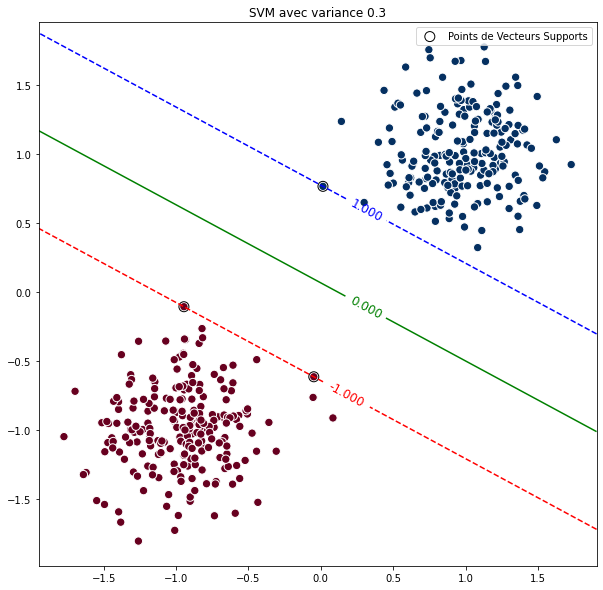

In [227]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
dessiner_sklearn(svm_lin, X_train, y_train, label="SVM avec variance 0.3")

### Augmentation de la Variance des classes Gaussiennes du 0.3 au 0.6

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.983 (+/-0.019) for {'C': 1, 'kernel': 'linear'}
0.991 (+/-0.018) for {'C': 10, 'kernel': 'linear'}
0.988 (+/-0.015) for {'C': 100, 'kernel': 'linear'}
0.988 (+/-0.015) for {'C': 1000, 'kernel': 'linear'}
0.988 (+/-0.015) for {'C': 10000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



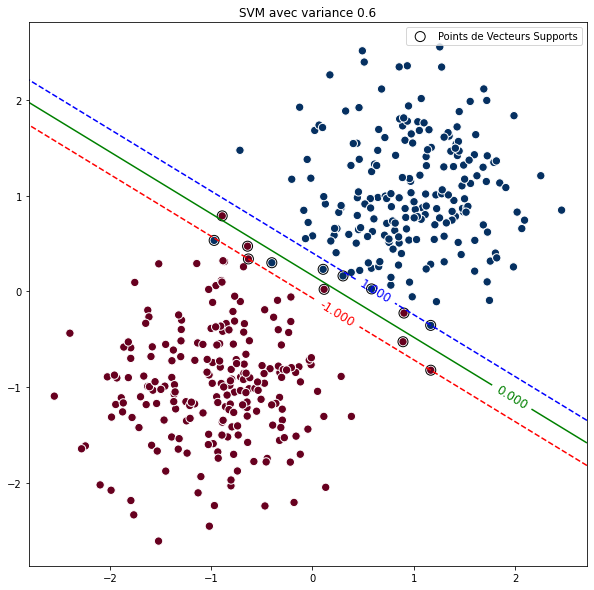

In [213]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
getHyperBestParam(X_train,y_train)
dessiner_sklearn(svm_lin, X_train, y_train, label="SVM avec variance 0.6")

- Lorsque la variance a augmenté, les données sont devenues linéairement non séparables, comme on le voit dans la nouvelle figure, le modèle est devenu plus complexe et il y a plus de risques d'erreurs.
- La marge entre la fonction de décision et les vecteurs de support a diminué, donc ici l'hyper-paramètre C jouera un rôle plus important que lorsque nous avions une variance de 0,3 (linéairement séparable). 
- Comme nous pouvons le voir, le taux de précision passe de 1 à 0.991 pour C = 10.



# 2 Reconnaissance de chiffres manuscrits

In [24]:
mnist = fetch_openml('mnist_784',version=1)

X = mnist['data']
y = mnist['target']
X_train, X_test, y_train, y_test = X[:60000],X[60000:], y[:60000], y[60000:]

fonction pour separer des chiffres specifique en 2 ou 3 classes

In [128]:
def seprer_en_classes(X, y, classe_1, classe_2, classe_3 = -1):
    
    if int(classe_3) > -1 :
        extract_classes = np.logical_or(y == classe_1, y == classe_2)
        extract_classes=np.logical_or(extract_classes,y == classe_3)
        X_classes = X[extract_classes]
        y_classes = y[extract_classes]
    else:
        extract_classes = np.logical_or(y == classe_1, y == classe_2)
        X_classes = X[extract_classes]
        y_classes = y[extract_classes]
        y_classes=np.where(y_classes==classe_1,1,y_classes)
        y_classes=np.where(y_classes==classe_2,-1,y_classes)
    
    X_classes = X_classes.to_numpy()
    y_classes = y_classes.astype('int')
    
    
    return X_classes, y_classes

## Isolation des classes 1 et 8

In [129]:
classe_1 = "1"
classe_2 = "8"
X_train_classes, y_train_classes = seprer_en_classes(X_train, y_train, classe_1, classe_2)
X_test_classes, y_test_classes = seprer_en_classes(X_test, y_test, classe_1, classe_2)

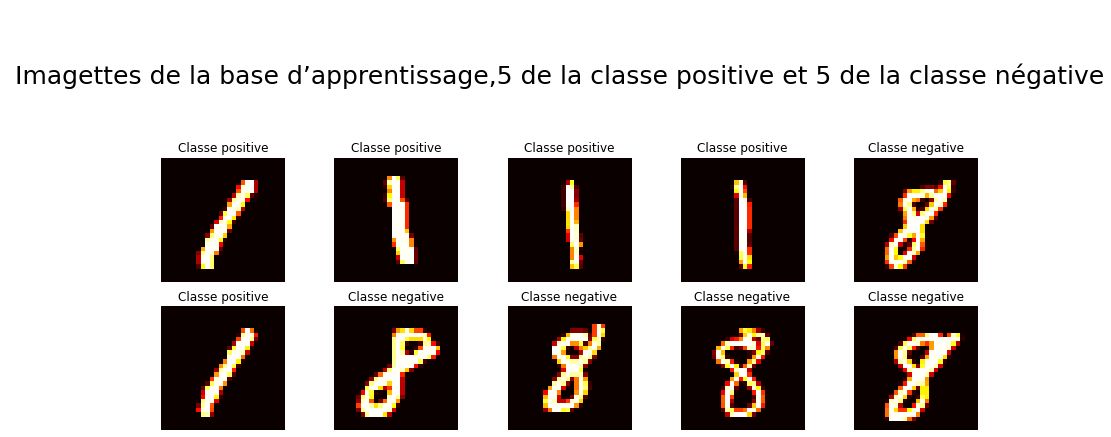

In [103]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("\n\n Imagettes de la base d’apprentissage," +
             "5 de la classe positive et 5 de la classe négative"
            , fontsize="25"
            , y = 1.3)
columns = 5
rows = 2
cont_x = 0
cont_y = 0

for i in range(len(y_train_classes)):
    if(cont_x != 5):
        if(y_train_classes[i] == 1):
            cont_x += 1
            digit = X_train_classes[i]
            digit_pixels = np.array(digit).reshape(28, 28)
            fig.add_subplot(rows, columns, cont_x+cont_y)
            plt.imshow(digit_pixels, cmap="hot")
            plt.title("Classe positive")
            plt.axis('off')
            
    if(cont_y != 5):
        if(y_train_classes[i] == -1):
            cont_y += 1
            digit = X_train_classes[i]
            digit_pixels = np.array(digit).reshape(28, 28)
            fig.add_subplot(rows, columns, cont_x+cont_y)
            plt.imshow(digit_pixels, cmap="hot")
            plt.title("Classe negative")
            plt.axis('off')
            
    if(cont_x + cont_y == 10):
        break

### Apprentissage d'un classifieur linéaire SVM


   - validation croisée (K-fold)

In [104]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5)
C=[0.0001,0.001,0.01,0.1,1,10,100]
scores=[]
y_train_classes = y_train_classes.astype('int')
for i in C:
    svc=SVC(C=i, kernel = "linear")
    scores.append(np.mean([svc.fit(X_train_classes[train], y_train_classes[train]).score(X_train_classes[test], y_train_classes[test])
                           for train, test in k_fold.split(X_train_classes)]))

In [115]:
maxscore = max(scores)
for i in range(len(scores)):
    if scores[i] == maxscore :
        print("\n---------------> C avec le meilleur score <---------------\n")
    print("Pour C= " , C[i] , "  Score = ",scores[i]   )
    if scores[i] == maxscore :
        print("\n----------------------------------------------------------")


---------------> C avec le meilleur score <---------------

Pour C=  0.0001   Score =  0.9785596425072546

----------------------------------------------------------
Pour C=  0.001   Score =  0.9738745187094366
Pour C=  0.01   Score =  0.9739539468269902
Pour C=  0.1   Score =  0.9739539468269902
Pour C=  1   Score =  0.9739539468269902
Pour C=  10   Score =  0.9739539468269902
Pour C=  100   Score =  0.9739539468269902


   - relancement de l’apprentissage du SVM sur la base d’apprentissage complète avec C = 0.0001

In [117]:
svc=SVC(C=0.0001, kernel = "linear")
svc.fit(X_train_classes,y_train_classes)
y_pred=svc.predict(X_test_classes)

- Test de performance du classifieur obtenu

In [118]:
from sklearn.metrics import accuracy_score
y_test_classes = y_test_classes.astype('int')
print("Le taux de bonne classification = ", accuracy_score(y_pred,y_test_classes))

Le taux de bonne classification =  0.9881460407776197


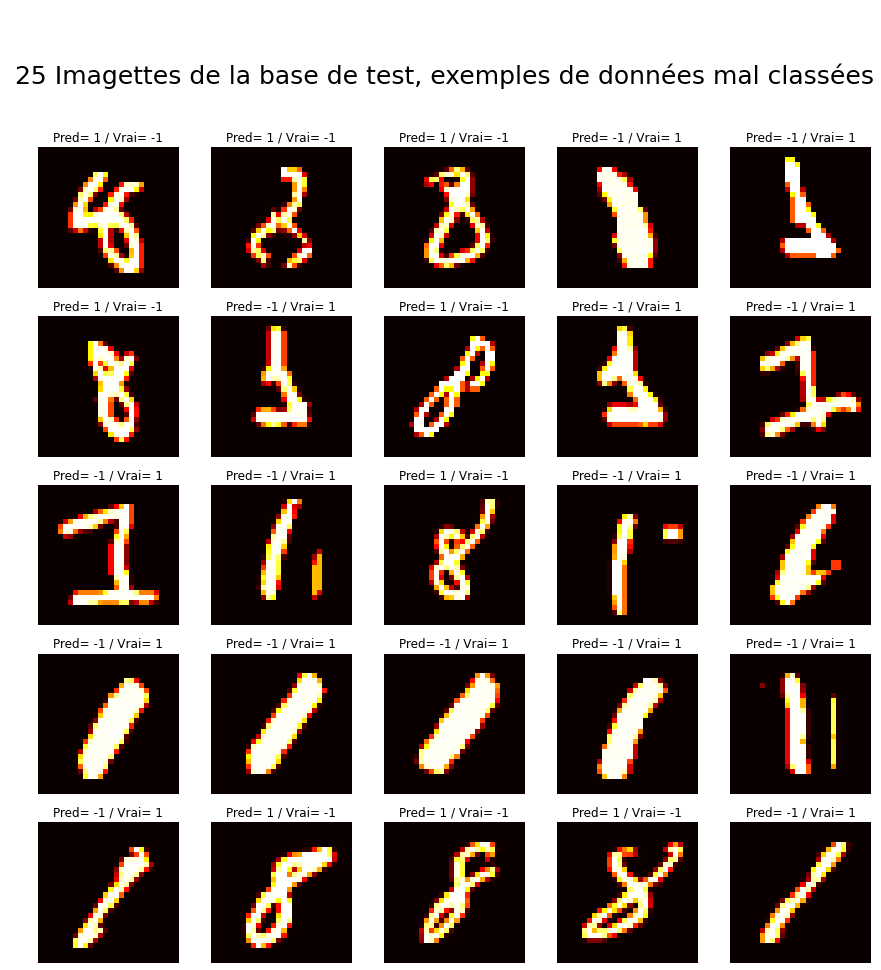

In [143]:
fig = plt.figure(figsize=(15, 15))
plt.suptitle("\n\n 25 Imagettes de la base de test," +
             " exemples de données mal classées"
            , fontsize="25"
            , y = 1.01)
columns =5
rows = 5
x=0
for i in range(len(y_pred)):
    
    if(y_test_classes[i] != y_pred[i]):
        x += 1
        digit = X_test_classes[i]
        digit_pixels = np.array(digit).reshape(28, 28)
        fig.add_subplot(rows, columns, x)
        plt.imshow(digit_pixels, cmap="hot")
        plt.title("Pred= " + str(y_pred[i]) + " / Vrai= " + str(y_test_classes[i]))
        plt.axis('off')
            
    if(x==25):
        break

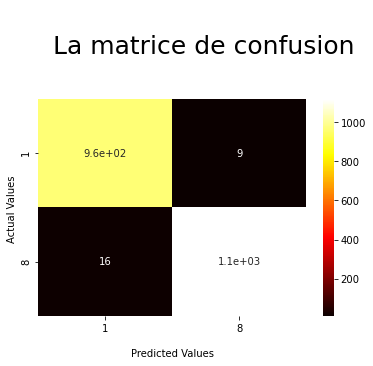

In [130]:
cf_matrix = confusion_matrix(y_test_classes, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='hot')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels([classe_1,classe_2])
ax.yaxis.set_ticklabels([classe_1,classe_2])
plt.suptitle("\n La matrice de confusion", fontsize="25", y = 1.2)
plt.show()

D'apres la matrice de confusion on peux dire que le modele a fait tres petites erreurs:
- 9(False Positive) Positive mais il sont negative dans les donnees de test initial
- 16(False Negative) Negative mais il sont Positive dans les donnees de test initial 

## Isolation des classes 1 et 7

In [159]:
classe_1 = "1"
classe_2 = "7"
X_train_classes, y_train_classes = seprer_en_classes(X_train, y_train, classe_1, classe_2)
X_test_classes, y_test_classes = seprer_en_classes(X_test, y_test, classe_1, classe_2)

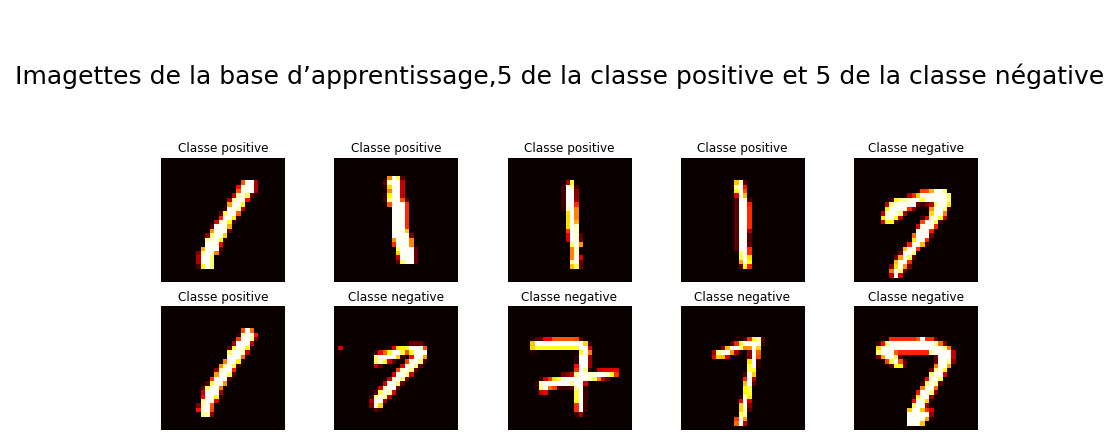

In [146]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("\n\n Imagettes de la base d’apprentissage," +
             "5 de la classe positive et 5 de la classe négative"
            , fontsize="25"
            , y = 1.3)
columns = 5
rows = 2
cont_x = 0
cont_y = 0

for i in range(len(y_train_classes)):
    if(cont_x != 5):
        if(y_train_classes[i] == 1):
            cont_x += 1
            digit = X_train_classes[i]
            digit_pixels = np.array(digit).reshape(28, 28)
            fig.add_subplot(rows, columns, cont_x+cont_y)
            plt.imshow(digit_pixels, cmap="hot")
            plt.title("Classe positive")
            plt.axis('off')
            
    if(cont_y != 5):
        if(y_train_classes[i] == -1):
            cont_y += 1
            digit = X_train_classes[i]
            digit_pixels = np.array(digit).reshape(28, 28)
            fig.add_subplot(rows, columns, cont_x+cont_y)
            plt.imshow(digit_pixels, cmap="hot")
            plt.title("Classe negative")
            plt.axis('off')
            
    if(cont_x + cont_y == 10):
        break

### Apprentissage d'un classifieur linéaire SVM


   - validation croisée (K-fold)

In [150]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5)
C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
scores=[]
y_train_classes = y_train_classes.astype('int')
for i in C:
    svc=SVC(C=i, kernel = "linear")
    scores.append(np.mean([svc.fit(X_train_classes[train], y_train_classes[train]).score(X_train_classes[test], y_train_classes[test])
                           for train, test in k_fold.split(X_train_classes)]))

In [151]:
maxscore = max(scores)
for i in range(len(scores)):
    if scores[i] == maxscore :
        print("\n---------------> C avec le meilleur score <---------------\n")
    print("Pour C= " , C[i] , "  Score = ",scores[i]   )
    if scores[i] == maxscore :
        print("\n----------------------------------------------------------")


---------------> C avec le meilleur score <---------------

Pour C=  1e-05   Score =  0.9951563299280919

----------------------------------------------------------
Pour C=  0.0001   Score =  0.9943106787107544
Pour C=  0.001   Score =  0.9943106787107544
Pour C=  0.01   Score =  0.9943106787107544
Pour C=  0.1   Score =  0.9943106787107544
Pour C=  1   Score =  0.9943106787107544
Pour C=  10   Score =  0.9943106787107544
Pour C=  100   Score =  0.9943106787107544


   - relancement de l’apprentissage du SVM sur la base d’apprentissage complète avec C = 0.0001

In [152]:
svc=SVC(C=0.00001, kernel = "linear")
svc.fit(X_train_classes,y_train_classes)
y_pred=svc.predict(X_test_classes)

- Test de performance du classifieur obtenu

In [154]:
from sklearn.metrics import accuracy_score
y_test_classes = y_test_classes.astype('int')
print("Le taux de bonne classification = ", accuracy_score(y_pred,y_test_classes))

Le taux de bonne classification =  0.9930651872399445


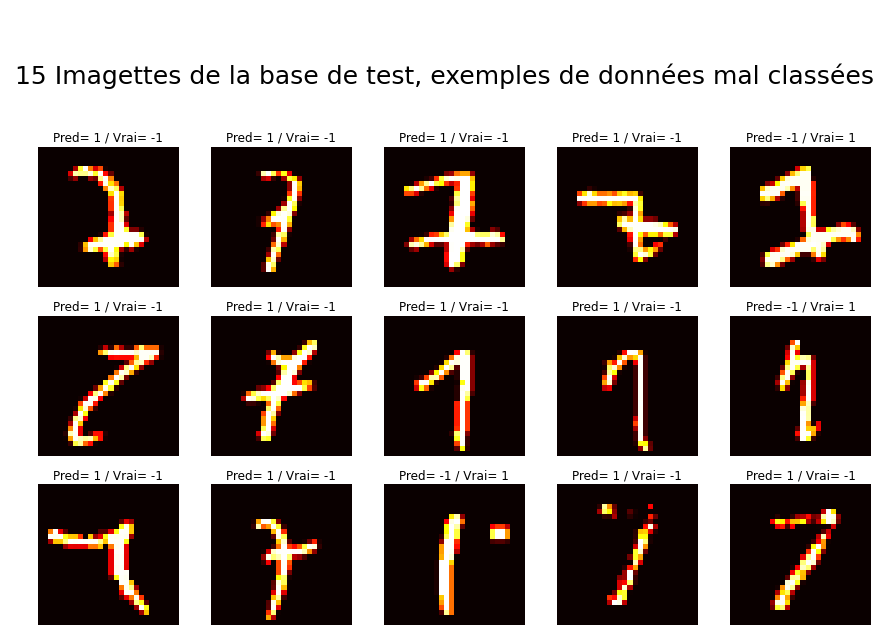

In [156]:
fig = plt.figure(figsize=(15, 15))
plt.suptitle("\n\n 15 Imagettes de la base de test," +
             " exemples de données mal classées"
            , fontsize="25"
            , y = 1.01)
columns =5
rows = 5
x=0
for i in range(len(y_pred)):
    
    if(y_test_classes[i] != y_pred[i]):
        x += 1
        digit = X_test_classes[i]
        digit_pixels = np.array(digit).reshape(28, 28)
        fig.add_subplot(rows, columns, x)
        plt.imshow(digit_pixels, cmap="hot")
        plt.title("Pred= " + str(y_pred[i]) + " / Vrai= " + str(y_test_classes[i]))
        plt.axis('off')
            
    if(x==25):
        break

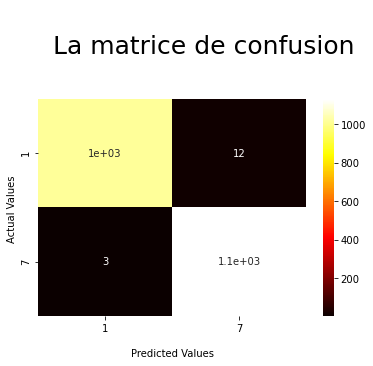

In [160]:
cf_matrix = confusion_matrix(y_test_classes, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='hot')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels([classe_1,classe_2])
ax.yaxis.set_ticklabels([classe_1,classe_2])
plt.suptitle("\n La matrice de confusion", fontsize="25", y = 1.2)
plt.show()

D'apres la matrice de confusion on peux dire que le modele a fait tres petites erreurs:
- 12 (False Positive) Positive mais ils sont negative dans les donnees de test initial
- 3 (False Negative) Negative mais ils sont Positive dans les donnees de test initial 

## Isolation des classes 0, 2 et 8 

In [164]:
classe_1 = "0"
classe_2 = "2"
classe_3 = "8"
X_train_3_classes, y_train_3_classes = seprer_en_classes(X_train, y_train, classe_1, classe_2,classe_3)
X_test_3_classes, y_test_3_classes = seprer_en_classes(X_test, y_test, classe_1, classe_2,classe_3)

In [177]:
svm_3d = LinearSVC(max_iter=10000,dual = False,C=10)
svm_3d.fit(X_train_3_classes,y_train_3_classes)

LinearSVC(C=10, dual=False, max_iter=10000)

In [178]:
ypredd = svm_3d.predict(X_test_3_classes)

In [191]:
y_train_pred = svm_3d.decision_function(X_train_3_classes)    
y_test_pred = svm_3d.decision_function(X_test_3_classes) 

In [193]:
y_test_3_classes = y_test_3_classes.to_numpy()

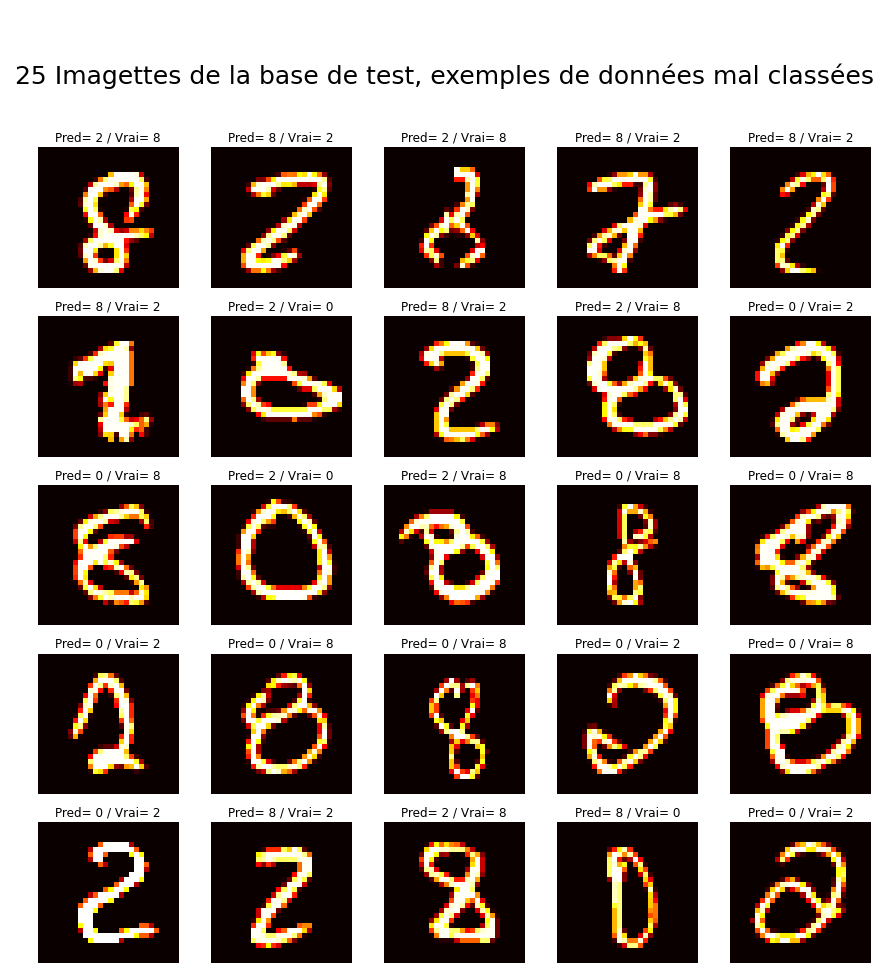

In [196]:
fig = plt.figure(figsize=(15, 15))
plt.suptitle("\n\n 25 Imagettes de la base de test," +
             " exemples de données mal classées"
            , fontsize="25"
            , y = 1.01)
columns =5
rows = 5
x=0
for i in range(len(ypredd)):
    
    if(y_test_3_classes[i] != ypredd[i]):
        x += 1
        digit = X_test_3_classes[i]
        digit_pixels = np.array(digit).reshape(28, 28)
        fig.add_subplot(rows, columns, x)
        plt.imshow(digit_pixels, cmap="hot")
        plt.title("Pred= " + str(ypredd[i]) + " / Vrai= " + str(y_test_3_classes[i]))
        plt.axis('off')
            
    if(x==25):
        break

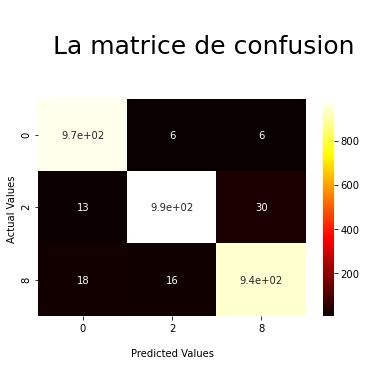

In [179]:
cf_matrix = confusion_matrix(y_test_3_classes, ypredd)

ax = sns.heatmap(cf_matrix, annot=True, cmap='hot')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels([classe_1,classe_2,classe_3])
ax.yaxis.set_ticklabels([classe_1,classe_2,classe_3])
plt.suptitle("\n La matrice de confusion", fontsize="25", y = 1.2)
plt.show()

D'apres la matrice de confusion on peux dire que le modele a fait des petites erreurs:

- 12 (False 0) prédites 0 mais dans les donnees de test initial:
    - 6 chiffres : 2 
    - 6 chiffres : 8
- 43 (False 2) prédites 2 mais dans les donnees de test initial:
    - 13 chiffres : 0
    - 30 chiffres : 8
- 34 (False 8) prédites 8 mais dans les donnees de test initial:
    - 18 chiffres : 0
    - 16 chiffres : 2
- Tous le reste sont prédites correctement:
    - 970 chiffres : predites 0 et dans les donnees de test initial ils sont 0
    - 990 chiffres : predites 2 et dans les donnees de test initial ils sont 2
    - 940 chiffres : predites 8 et dans les donnees de test initial ils sont 8

In [190]:
print("La stratégie multiclasse utilisée par cette implémentation est: ", svm_3d.multi_class, " = One Versus Rest")

La stratégie multiclasse utilisée par cette implémentation est:  ovr  = One Versus Rest
